<center>
    <img src="https://www.ua.pt/imgs/logo.svg" width="400"/>
</center>

# Fundamentos de Ciência de Dados
Estimated time needed: **70** minutes

## Work made by:
- João António, nº 76558, joaoantonio@ua.pt, Mestrado em ciência de dados (9306)
- Tiago Freitas, nº 76748, tiagofreitas79@ua.pt, Mestrado em ciência de dados (9306)

### Quote:
> "In Linus Torvalds we trust, rest bring data" - adapted from a common american saying

## Objectives

*   Data cleaning of INE Cultures dataset
*   Analyze visually the cultures per year
*   Data Cleaning of IPMA dataset
*   Explore IPMA & INE Cultures
*   Train a few regression models

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1.  [INE Cultures](#1)<br>
2.  [Cultures per Year](#2)<br>
3.  [IPMA](#3) <br>
4.  [Cultures vs IPMA](#4) <br>
5.  [Regplot](#5) <br>
6.  [Machine Learning](#6) <br>
7.  [Future Work](#7) <br>
</div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
import json
from plotly import graph_objects as go
import matplotlib.patches as mpatches # needed for waffle Charts
import contextlib

In [3]:
%matplotlib inline

## 1.INE Cultures<a id="1"></a>

### 1.1. Information on INE data
Organizações não governamentais de ambiente por 100 000 habitantes (N.º) por Localização geográfica (NUTS - 2013); Anual
https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0008290&contexto=bd&selTab=tab2

Base de dados: Nuts 2013


Sinais convencionais:
Sinais convencionais por ausência de valor
- `…`	Dado confidencial
- `-`	Dado nulo ou não aplicável
- `x`	Dado não disponível
- `o`	Dado inferior a metade do módulo da unidade utilizada
- `∞`	Infinito

Sinais convencionais adicionais ao valor
- `//` Dado preliminar
- `&`	Dado provisório
- `»`	Dado previsto
- `*`	Dado rectificado
- `§`	Desvio do padrão de qualidade/Coeficiente de variação elevado
- `“`	Estimativa
- `“E` Dado estimado pelo Eurostat
- `┴`	Quebra de série/comparabilidade
- `i`	Mais informação em anexo

Sinais convencionais diversos:
- `µ`	Média
- `=`	Igual
- `>`	Maior que
- `≥`	Maior ou igual
- `<`	Menor que
- `≤`	Menor ou igual
- `%`	Percentagem
- `‰`	Permilagem
- `∑`	Soma de
- `≠`	Diferente

### 1.2. Data Load and Processing

In [4]:
file_csv = "./data_FCD/ine_principais_culturas_agricolas.csv"

In [5]:
# Data relating to Portugal map
with open("./data_FCD/Portugal.json", "r", encoding="utf-8") as read_file:
    world_geo = json.load(read_file)

In [6]:
def load_ine_cultures(file_csv):
    df=pd.read_csv(file_csv,delimiter=";", encoding="latin-1", header=[4, 6], nrows=12, on_bad_lines="skip")    

    ## Drop Columns
    df.drop(labels=[0], inplace=True) # Drop first row
    df.drop(columns=df.columns[-1], inplace=True) # Drop last column
    
    df.drop(labels=[9,11], inplace=True) # Drop repeated Açores and Madeira rows
    
    ## Reset of the Index as Region with just the region codes
    df['Region_split'] = df[df.columns[0]].apply(lambda x : str(x).rsplit(sep = ':', maxsplit=1))
    df['Region']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['Region_names']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
    region_names = df["Region_names"].to_list()
    df.set_index("Region", inplace=True)
    columns_to_rem = [0, -1, -2] # Remove Unnamed: 0_level_1(1st), Region_split(last) and Region_names(before last) columns
    df.drop(df.columns[columns_to_rem], axis=1, inplace=True)
    
    ## Changed regions names to just one word per region to make it easier for graphical representations later
    for k_ind, k in enumerate(region_names):
        k_split = k.split(" ")
        if len(k_split) > 1:
            region_names[k_ind] = k_split[-1]
    
    ## Redo the Headers, from unnamed to the year
    c0 = df.columns.get_level_values(0).to_series()
    c1 = list(df.columns.get_level_values(1).to_series())
    c0 = c0.mask(lambda c: c.str.startswith("Unnamed")).ffill()
    df.columns = [c0, c1]
    
    ## Bringing the year to the index
    df = df.stack(level=0)
    df.index.names=['Region', 'Year']
    
    ## Replacing 'x', 'x x', '- -' for their respective value
    df.replace({'x':np.nan,'x x':np.nan,'- -':0,'nan':np.nan},inplace=True)
    
    ## Replacing provisional data 
    for column in df:
        df[column]=df[column].map(lambda x: str(x).rstrip(' &'))
        df[column]=df[column].map(lambda x: str(x).rstrip(' *'))
        
    # This method turns data to stringd so we have to turn the data back to numeric
    for column in df:
        df[column]=pd.to_numeric(df[column],'coerce')
        
    # Transform para SLUG o açores to avoid slug issues
    region_names[-2] = "Acores"
    return df, region_names

In [7]:
data, region_names = load_ine_cultures(file_csv)
data

Abacate  Abóbora (inclui butternut)  Alface  Alho  Alho-porro  \
Region Year                                                                  
PT     1986      NaN                         NaN     NaN   NaN         NaN   
       1987      NaN                         NaN     NaN   NaN         NaN   
       1988      NaN                         NaN     NaN   NaN         NaN   
       1989      NaN                         NaN     NaN   NaN         NaN   
       1990      NaN                         NaN     NaN   NaN         NaN   
...              ...                         ...     ...   ...         ...   
3      2017      NaN                         NaN     NaN   NaN         NaN   
       2018      0.0                         NaN     NaN   NaN         NaN   
       2019   8243.0                         NaN     NaN   NaN         NaN   
       2020   9164.0                         NaN     NaN   NaN         NaN   
       2021   9726.0                         NaN     NaN   NaN         NaN   

             Ameixa  Amoras  Amêndoa  Ananás  Arroz  ...  Trigo  Trigo duro  \
Region Year                                          ...                      
PT     1986    6006     NaN      848     NaN   4463  ...   1630        1250   
       1987    6266     NaN      996     NaN   4322  ...   1694        1355   
       1988    5173     NaN      506     NaN   4266  ...   1380         789   
       1989    5769     NaN     1237     NaN   4290  ...   1915        1197   
       1990    6436     NaN     1098     NaN   4614  ...   1429        1270   
...             ...     ...      ...     ...    ...  ...    ...         ...   
3      2017    7529     NaN        0     0.0      0  ...   1986           0   
       2018    7760     0.0        0     0.0      0  ...   1986           0   
       2019    8339     0.0        0     0.0      0  ...   2002           0   
       2020    5880     0.0        0     0.0      0  ...   1988           0   
       2021    5018     0.0        0     0.0      0  ...   2002           0   

             Trigo mole  Triticale  Uva de mesa  Uva para vinho  \
Region Year                                                       
PT     1986        1669       1405         6720            4122   
       1987        1727       1410         7702            5765   
       1988        1425       1237         3179            1965   
       1989        1977       1666         5517            3963   
       1990        1445       1244         5740            5806   
...                 ...        ...          ...             ...   
3      2017        1986          0         7881            5490   
       2018        1986          0         7881            4386   
       2019        2002          0         7881            6224   
       2020        1988          0         7883            5980   
       2021        2002          0         7883            6474   

             Uva para vinho (DOP)  Uva para vinho (IGP)  \
Region Year                                               
PT     1986                   NaN                   NaN   
       1987                   NaN                   NaN   
       1988                   NaN                   NaN   
       1989                   NaN                   NaN   
       1990                   NaN                   NaN   
...                           ...                   ...   
3      2017                   NaN                   NaN   
       2018                   NaN                   NaN   
       2019                   NaN                   NaN   
       2020                   NaN                   NaN   
       2021                   NaN                   NaN   

             Uva para vinho (Vinhos sem certificação)  Vinha  
Region Year                                                   
PT     1986                                       NaN   4199  
       1987                                       NaN   5824  
       1988                                       NaN   2002  
       1989    

## 2.Cultures per Years <a id="2"></a>

### 2.1. Production by Region for a specific year

In [8]:
#? Select year to study (string)
year_to_study='2020' #default='2020'

#? Select Products
labels_to_plot = ["Trigo", "Arroz", "Amêndoa", "Trigo mole", "Trigo duro", "Uva para vinho"]

<Figure size 1600x800 with 0 Axes>

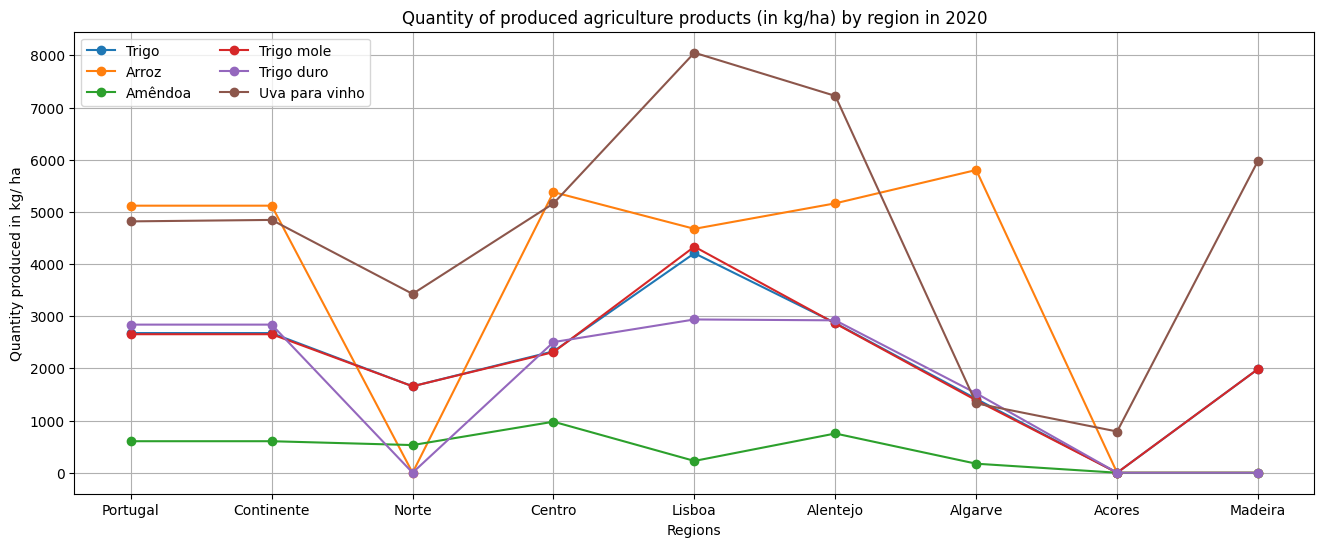

In [9]:
plt.figure(figsize=(16, 8))
df_year=data.xs(year_to_study, level=1)

df_year.columns
## Obtain index of Specific Products draw those index on plot
index_to_plot = [list(df_year.columns).index(product) for product in labels_to_plot]

# filter_col = ["Trigo", "Trigo duro", "Ananás", "Amêndoa",]
df_year[df_year.columns[index_to_plot]].plot(figsize=(16, 6), marker="o")
plt.title(f"Quantity of produced agriculture products (in kg/ha) by region in {year_to_study}")
plt.xlabel("Regions")
plt.ylabel("Quantity produced in kg/ ha")
plt.legend(loc="upper left", ncol=2)
plt.grid()
plt.xticks(range(len(region_names)), region_names)
plt.show()
# plt.savefig("Production_2020.png")

### 2.2. Map of production for a given year and product

In [10]:
def map_date(product, year_selected):
    df_year=data.xs(year_selected, level=1)
    d = {
        region: df_year[product][df_year[product].index[k]]
        for k, region in enumerate(region_names)
    }
    df_product_region = pd.DataFrame(d.items(), columns=['City/County', 'Values'])

    df_product_region = df_product_region.set_index("City/County")


    new_d = {}
    for k in range(20):
        name = world_geo["features"][k]["properties"]["name"]
        region = world_geo["features"][k]["properties"]["region"]
        new_d[name] = df_product_region.loc[region][0]

    return  pd.DataFrame(new_d.items(), columns=['City/County', 'Values']), df_product_region

        

In [11]:
# ? Select year, product and colorscale
year_selected = "2020"
product = "Uva para vinho"
colorscale="rainbow" #rainbow, sunsetdark, blues, cividis, brwnyl

In [12]:
df_name, df_product_region = map_date(product, year_selected)
#Create figure object
fig = go.Figure(
    go.Choroplethmapbox(
        geojson = "./data_FCD/Portugal.json", #Assign geojson file
        featureidkey = "properties.name", #Assign feature key
        locations = df_name["City/County"], #Assign location data
        z = df_name["Values"], #Assign information data
        zauto = True,
        colorscale = colorscale,
        showscale = True,
    )
)


#Update layout
fig.update_layout(
    mapbox_style = "carto-positron", #Decide a style for the map
    mapbox_zoom = 3.8, #Zoom in scale
    mapbox_center = {"lat": 37.5, "lon": -17}, #Center location of the map
)

Example on how the above map should look for "Uva para vinho para 2020"
<center>
    <img src="figs/map plot uva para vinho.png" width="800"/>
</center>

### 2.3. Waffle chart for Product in specific year

In [13]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)

    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print(f'{df_product_region.index.values[i]}: {str(tiles)}')

    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[:category_index]):
                # ...proceed to the next category
                category_index += 1       

            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index

    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)


    cbar = plt.colorbar()
    cbar.set_ticks(range(1, len(values)+1))
    cbar.set_ticklabels(categories)


    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)

    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    plt.title(f"Waffle Chart of Product {product} in year {year_to_study}")
    plt.show()

Total number of tiles is 500
Norte: 54
Centro: 81
Lisboa: 126
Alentejo: 113
Algarve: 21
Acores: 12
Madeira: 94


<Figure size 640x480 with 0 Axes>

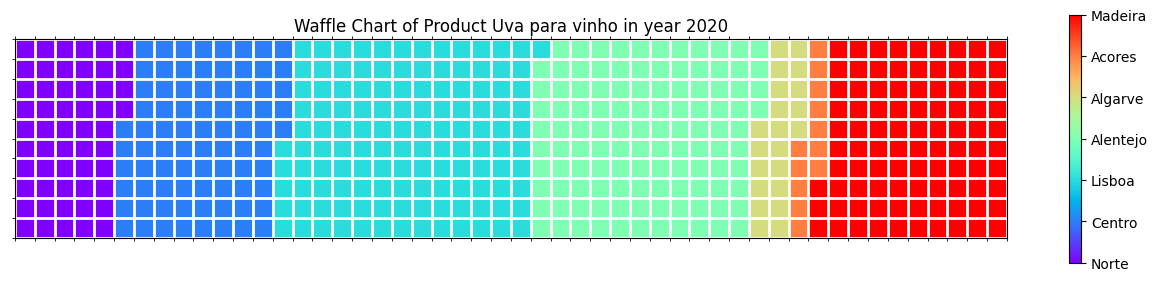

In [14]:
with contextlib.suppress(KeyError):
    df_product_region.drop(['Portugal', 'Continente'], inplace=True)
    
width = 50 # width of chart
height = 10 # height of chart


categories = df_product_region.index.values # categories
values = df_product_region['Values'] # correponding values of categories

colormap = plt.cm.rainbow # color map class
create_waffle_chart(categories, values, height, width, colormap)

### 2.4. Boxplot of productions by region

In [15]:
def boxplot_data():
    data_regions = data.reset_index()
    return data_regions.set_index("Year")

In [16]:
#? Select Product
product1 = "Milho"
product2 = "Tomate para indústria"

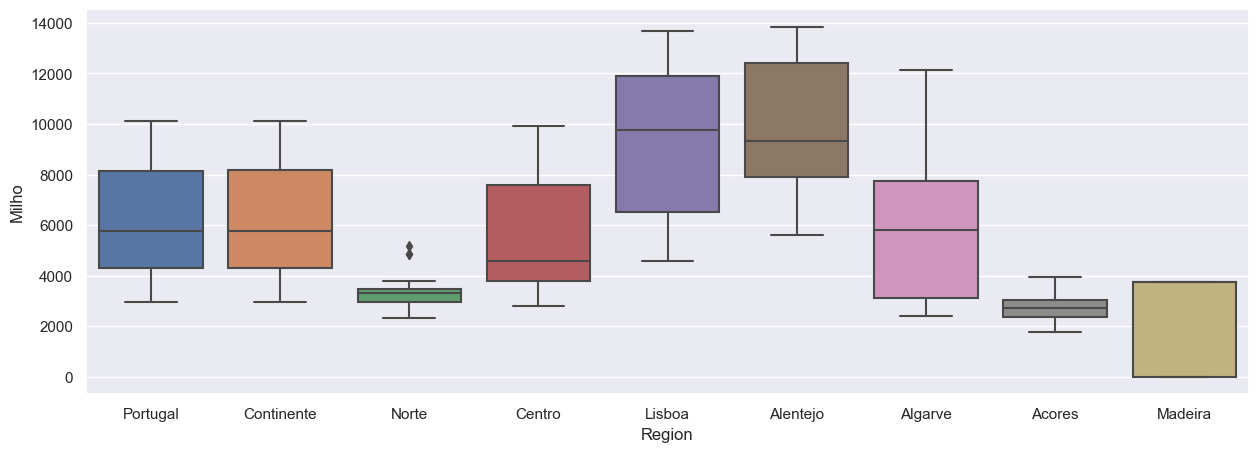

In [17]:
sns.set(rc = {'figure.figsize':(15,5)})
data_regions = boxplot_data()
sns.boxplot(data=data_regions, x="Region", y=product1)
plt.xticks(range(len(region_names)), region_names)
plt.show()

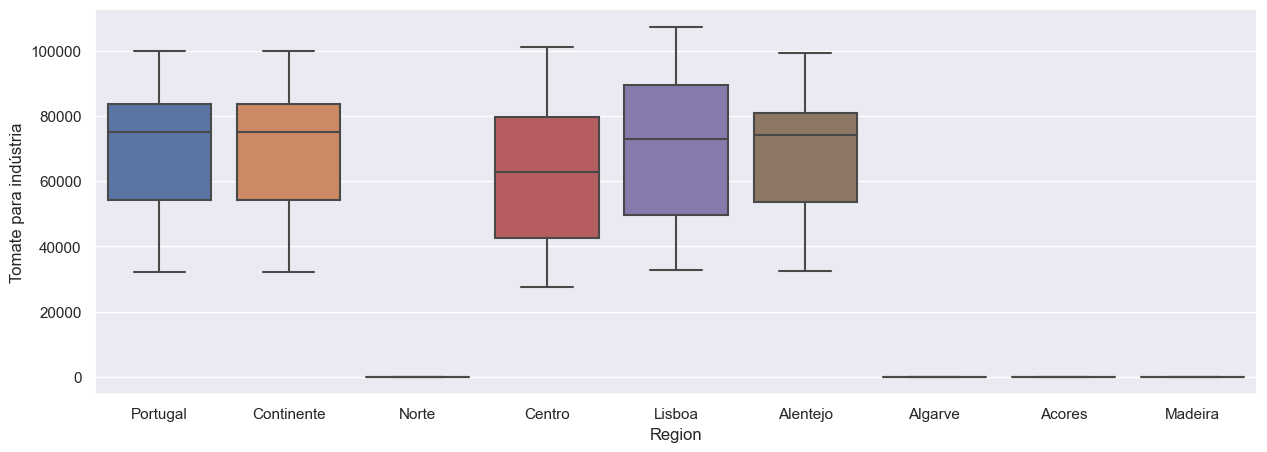

In [18]:
sns.set(rc = {'figure.figsize':(15,5)})
sns.boxplot(data=data_regions, x="Region", y=product2)
plt.xticks(range(len(region_names)), region_names)
plt.show()

### 2.5. Evolution of production
The main question was to compare how the products production evolved overtime using the 2000 as a baseline, and review the dataset for every 5 years thereafter.

In [19]:
#? Select baseline year, years to compare with baseline and region code
baseline_year = 2000
year_to_study =[2000, 2005, 2010, 2015, 2020]
region = 11

In [20]:
def evolution_baseline(region, baseline_year):
    def product_base_comp(region, year_study):
        data_region = data.xs(str(region))
        year_index = list(data_region.index).index(str(year_study))
        return data_region.iloc[year_index]

    d1 = pd.DataFrame()
    for year in year_to_study:
        d1[year] = product_base_comp(region, year)

    d1["temp"] = d1[baseline_year]
    for year in year_to_study:
        d1[year] /= d1["temp"]

    d1.dropna(axis = 0, how = 'all', inplace = True)
    d1.drop("temp", axis=1, inplace=True)
    return d1

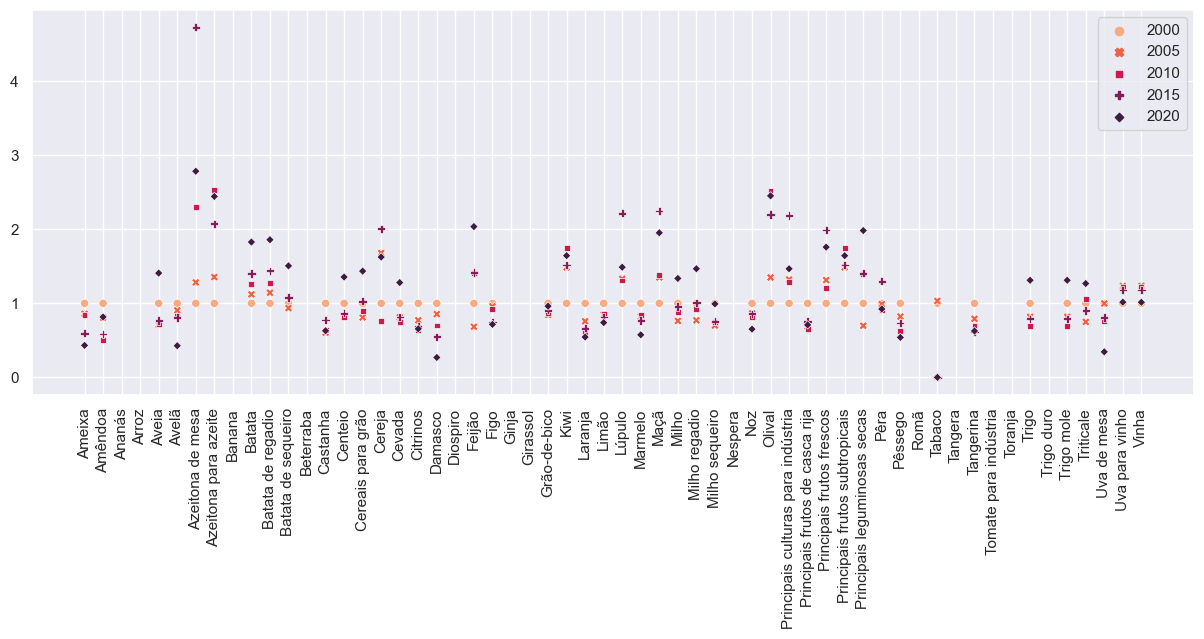

In [21]:
d1 = evolution_baseline(region, baseline_year)
sns.set(rc = {'figure.figsize':(15,5)})
sns.scatterplot(data=d1, palette='rocket_r')
plt.rcParams["xtick.labelsize"] = 10
plt.xticks(rotation=90)
plt.show()

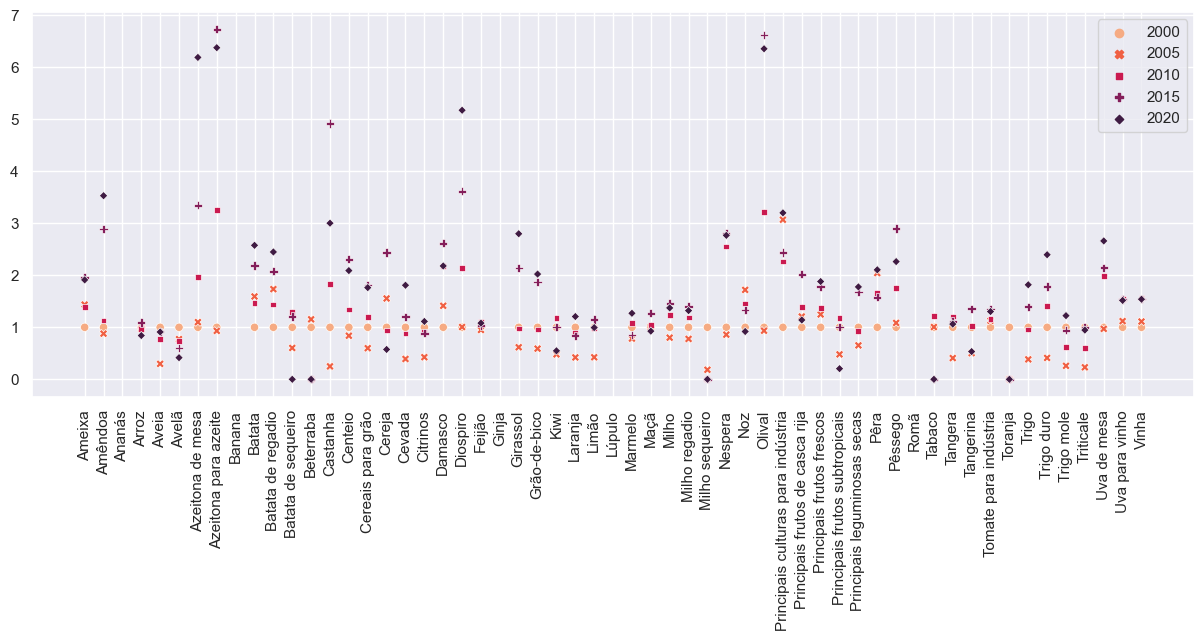

In [22]:
region = 18
d2 = evolution_baseline(region, baseline_year)
sns.set(rc = {'figure.figsize':(15,5)})
d2.drop('Figo', axis=0, inplace=True)
sns.scatterplot(data=d2, palette='rocket_r')
plt.rcParams["xtick.labelsize"] = 10
plt.xticks(rotation=90)
plt.show()

On the 2 graphs above we can see how the production changed from the 2000 to 2005, 2010, 2015, 2020.
On the second graph (region 18) we decided to remove the Figo, since it made a giant leap in production (20x), making it harder to see all the other products evolution.

By comparing the 2 graphs, the region 18 seems to evolve more leading a better production overall, while the region 11 seems to have decrease the production.

## 3.IPMA<a id="3"></a>

### 3.1 Loading IPMA Data
Note that the Structure of pages inside the Excel is given by:
- Shet 0 is metadata
- Shet 1 is tmin
- Shet 2 is tmax
- Shet 3 is Pluviosity

In [23]:
# Global Functions have the name in full capslock to respect pep8
# 1st Code is of the region, the second is the name of the IPMA
MAP_REGIONS_EXCEL = {
    "Norte": [11, 11],
    "Centro": [16, 132],
    "Lisboa": [17, 320],
    "Alentejo": [18, 571],
    "Algarve": [15, 554],
    "Açores": [2, 360],
    "Madeira": [3, 522],
}
IPMA_COLUMNS = ["Tmin", "Tmax", "Prec", "TmaxA", "TminA", "Prec_max", "Prec_min"]

In [24]:
def add_extra_col(meteo_coln, sheet_number):
    sheet_number += 1  # So that 1 is the Tmin, 2 is the Tmax and 3 is the precipitation
    index_describe = 1  # Mean

    if meteo_coln == "TmaxA":
        # Meaning T Max Ablsolute, so the real maximum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 2  # Tmax

    elif meteo_coln == "TminA":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 1  # Tmin

    elif meteo_coln == "Prec_min":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 3  # Precipitation Sheet

    elif meteo_coln == "Prec_max":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 3  # Precipitation Sheet

    for region, codes in MAP_REGIONS_EXCEL.items():
        meteo2 = pd.read_excel(
            f"./data_FCD/IPMA/{codes[1]}-tx-tn-prec.xlsx",
            sheet_name=sheet_number,
        )
        meteo2.dropna(axis=0, how="any", inplace=True)

        #Obtain only years after 1986
        meteo2 = meteo2[meteo2.year > 1986]
        meteo2.set_index("year", inplace=True)
        meteo2.index.names = ["Region"]
        
        # use the Describe that gives mean (index 1), max (index 7) and min (index 3)
        data_prec = meteo2.transpose().describe()
        index_names_arr = data_prec.index.values
        
        #Rename that column to region and drop the others
        index_names_arr[index_describe] = codes[0]
        for k_name in index_names_arr:
            if k_name != codes[0]:
                data_prec.drop(index=k_name, inplace=True)
        
        years_list = data_prec.keys()
        header = [years_list, [meteo_coln] * len(years_list)]
        data_prec.columns = header
        
        data_f = (
            data_prec
            if region == list(MAP_REGIONS_EXCEL.keys())[0]
            else pd.concat([data_f, data_prec])
        )
    return data_f


In [25]:
def load_ipma():
    ipma = {
        type_data: add_extra_col(type_data, k)
        for k, type_data in enumerate(IPMA_COLUMNS)
    }
    ## Make all the concats at the same time to save time
    meteo = pd.concat([ipma[k] for k in IPMA_COLUMNS], axis=1)
    # meteo["T_range"] = meteo["TmaxA"] - meteo["TminA"]
    meteo= meteo.stack(level=0)
    meteo.index.names = ["Region", "Year"]
    return meteo.reindex(sorted(meteo.columns), axis=1)

In [26]:
meteo = load_ipma()

## Added DTs
meteo['dT']=meteo['Tmax']-meteo['Tmin']
meteo['dTA']=meteo['TmaxA']-meteo['TminA']
meteo

Prec  Prec_max  Prec_min       Tmax      TmaxA       Tmin  \
Region Year                                                                    
11     1987  132.408333     478.1      10.2  14.991667  25.200000   6.300000   
       1988  109.783333     368.5       0.0  14.208333  24.000000   5.875000   
       1989  132.233333     652.1       0.4  15.800000  27.500000   7.016667   
       1990   79.175000     253.7       5.8  15.366667  26.700000   6.583333   
       1991  110.366667     262.1      11.1  14.533333  26.600000   5.741667   
...                 ...       ...       ...        ...        ...        ...   
3      2014   40.133333     111.5       0.0  22.800000  26.807143  17.104762   
       2015   24.958333     135.1       0.0  22.791667  27.000000  17.233333   
       2016   53.925000     163.1       0.0  22.975000  28.000000  17.358333   
       2017   31.416667     104.6       0.0  23.350000  26.800000  17.750000   
       2018   45.908333     163.5       0.0  22.750000  26.600000  17.241667   

                 TminA        dT     dTA  
Region Year                               
11     1987   0.200000  8.691667  25.000  
       1988   0.700000  8.333333  23.300  
       1989   0.300000  8.783333  27.200  
       1990   0.600000  8.783333  26.100  
       1991  -0.600000  8.791667  27.200  
...                ...       ...     ...  
3      2014  13.832143  5.695238  12.975  
       2015  13.300000  5.558333  13.700  
       2016  14.100000  5.616667  13.900  
       2017  14.200000  5.600000  12.600  
       2018  13.500000  5.508333  13.100  

[209 rows x 9 columns]

If you look into this table we can see that Madeira (region 3) has some strange values for temperature, most of Tmin is zero

### 3.2. Correlation between our columns of Meterologic Data

Here we can see some expected correlations:
 - High correlation between `Prec` and `Prec_max` (`Prec_min` doesn´t have high correlation probably due to the years where it is 0)
 - Some correlation between the `Tmax` and `Tmin`
 - Very high correlation between `Tmin` and `TminA` and between `dT` and `dTA`
 - Some other smaller correlation between Temperature values

<img src="figs/meteo_pairplot.png" style="width:1400px;height:1000px;">
<caption><center> **Fig. 1** : ** Pair plot of the Meteo Data** </center></caption>

<!-- <img src=“FCD/figs/meteo_pairplot.png”/> -->

In [27]:
def pairplot_data():
    meteo2 = meteo.reset_index()
    meteo2["Region"] = meteo2["Region"].replace({11:"Norte",
    16:"Centro",
    17:"Lisboa",
    18:"Alentejo",
    15:"Algarve",
    2:"Açores",
    3:"Madeira"})
    meteo2.set_index("Year")
    return meteo2 

In [28]:
repeat_paiplot = 0

In [29]:
# A pairplot between all the meteo data that we are obtaining
if repeat_paiplot:
    plot_data = pairplot_data()
    sns.pairplot(plot_data, hue="Region", dropna=True)
    plt.show()

### 3.3. PCA for meteo data
Trying to study similarities between the years in terms of their metereological data for a specific region.

In [30]:
# Select region to study
meteo_region = meteo.xs(18)
# Some regions reult in error due to NaN values (2,11,15,16)
# Most of the regions that work have similar explained variance (~60%)

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca1=PCA(n_components=2)

meteo_scaled=StandardScaler().fit_transform(meteo_region)
principalComponents = pca1.fit_transform(meteo_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

meteo_pca = pca1.transform(meteo_scaled)

pca1.explained_variance_ratio_

array([0.36087116, 0.23055766])

Our PCA only covers around 60% of the variance of the data which is not very good. Still, it may be interesting to try to visualize some similarities using these two principal components (with 3 principal components the PCA covers ~77%).

(Before adding the dT and dTA intervals to the meto data the PCA would cover 74% with 2 components and 86% with 3. The results obtained were similar).

In [32]:
print(meteo_region.columns)
print(pca1.components_)

Index(['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA', 'dT',
       'dTA'],
      dtype='object')
[[-0.23245365 -0.12739086 -0.16177662  0.43997552  0.42154633  0.16803968
  -0.31963193  0.44150579  0.45492434]
 [ 0.50453243  0.53434658  0.29594187 -0.16323495  0.20399522 -0.18445303
  -0.39261511 -0.06268685  0.33463456]]


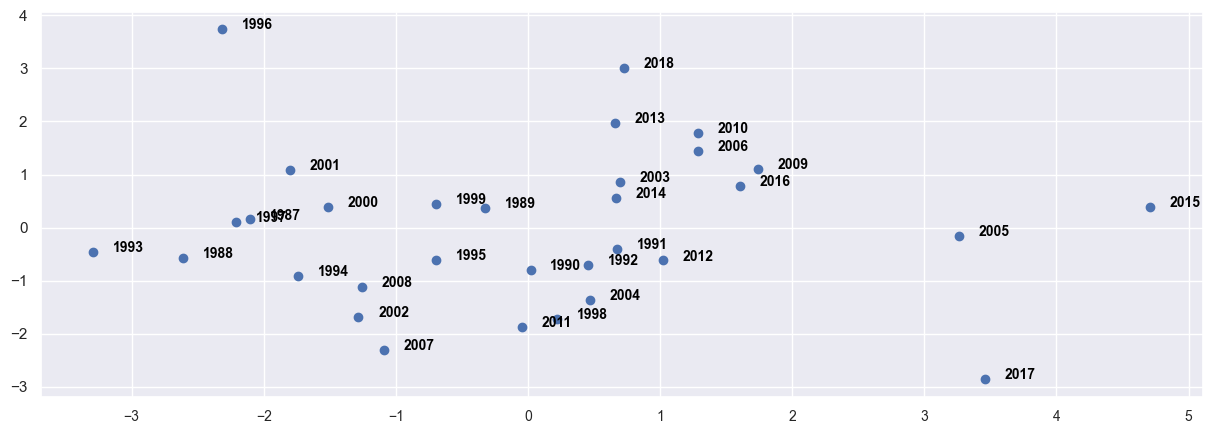

In [33]:
# Plotting the results
labels=meteo_region.index
plt.scatter(meteo_pca[:,0], meteo_pca[:,1], label=labels)
for line, label in enumerate(labels):
     plt.text(meteo_pca[:,0][line]+0.15, meteo_pca[:,1][line], label, horizontalalignment='left', size=10, color='black', weight='semibold')

One of the things we can observe in the figure above is that the meteorological data of a certain year can be very different from the previous year.

## 4.INE Cultures & IPMA<a id="4"></a>

### 4.1. Production of a certain region (Example of Trigo and Amêndoa in Alentejo)

In [34]:
#? Select region and products/meteo to compare (change labels when plotting)
region_study=18
filter_col = ["Trigo", "Amêndoa"]
col_to_draw = ["Prec_max"]

In [35]:
year = range(1986, 2022)
def create_df_trg_amd(filter_col, col_to_draw):
    df_alentejo_trig_amend = {
    }
    for k_col, col in enumerate(filter_col):
        if col not in df_alentejo_trig_amend:
            df_alentejo_trig_amend[col] = []
        for elem in data[col]["18"]:
            df_alentejo_trig_amend[col].append(elem)

    meteo_data = {}
    meteo_region=meteo.xs(region_study)
    for k_col, col in enumerate(col_to_draw):
        if col not in meteo_data:
            meteo_data[col] = []
        for elem in meteo_region[col]:
            meteo_data[col].append(elem)
        meteo_data["year"] = meteo_region[col].index
        
    for key in df_alentejo_trig_amend:
        df_alentejo_trig_amend[key] = MaxAbsScaler().fit_transform(np.array(df_alentejo_trig_amend[key]).reshape(-1, 1))
    return df_alentejo_trig_amend, meteo_data

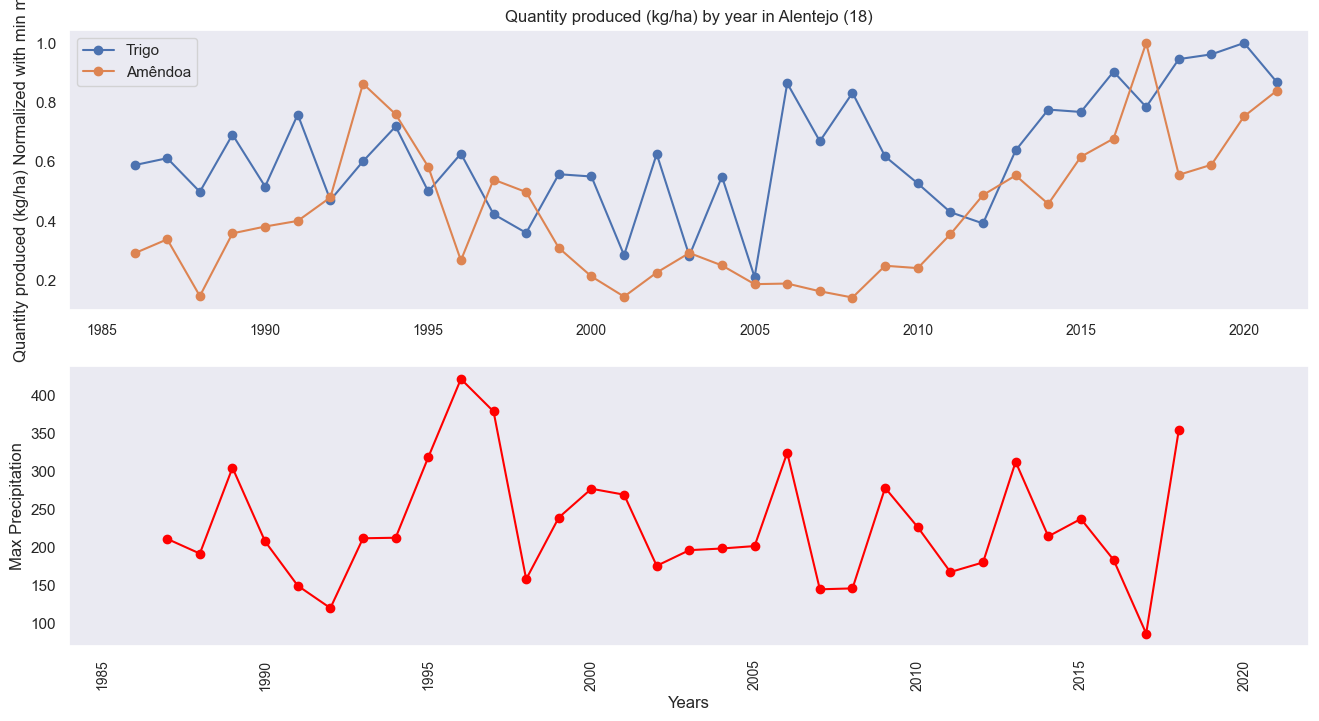

In [36]:
plot_data, plot_data2 = create_df_trg_amd(filter_col,col_to_draw)
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
for key in plot_data:
    ax.plot(year, plot_data[key], label=key, marker="o")
ax2.plot(plot_data2["year"], plot_data2["Prec_max"], color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced (kg/ha) Normalized with min max")
ax2.set_ylabel("Max Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity produced (kg/ha) by year in Alentejo (18)")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

### 4.2 Study of the Correlation between the Meteorologic Data and production (Example of Trigo for the North of Portugal)

In [37]:
#? Select Region and Products
region_study=11 # deafult=11
index_to_plot= ["Trigo"] # default=['Trigo']

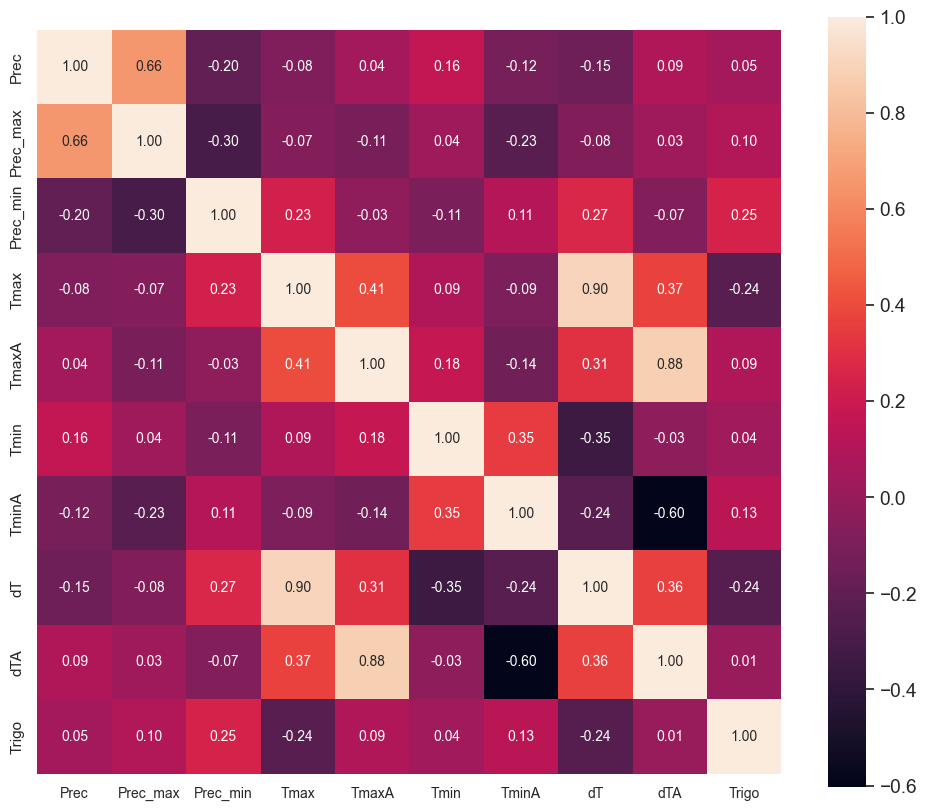

['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA', 'dT', 'dTA', 'Trigo']


In [38]:
meteo_region = meteo.xs(region_study)
data_region = data.xs(str(region_study))

index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(2019)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index("2019")
data_region = data_region[index_to_plot].iloc[range(index_min,index_max)]


f,ax = plt.subplots(figsize=(12, 10))
cols = list(meteo_region.columns)
cols.append("Trigo")
cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()
print(cols)

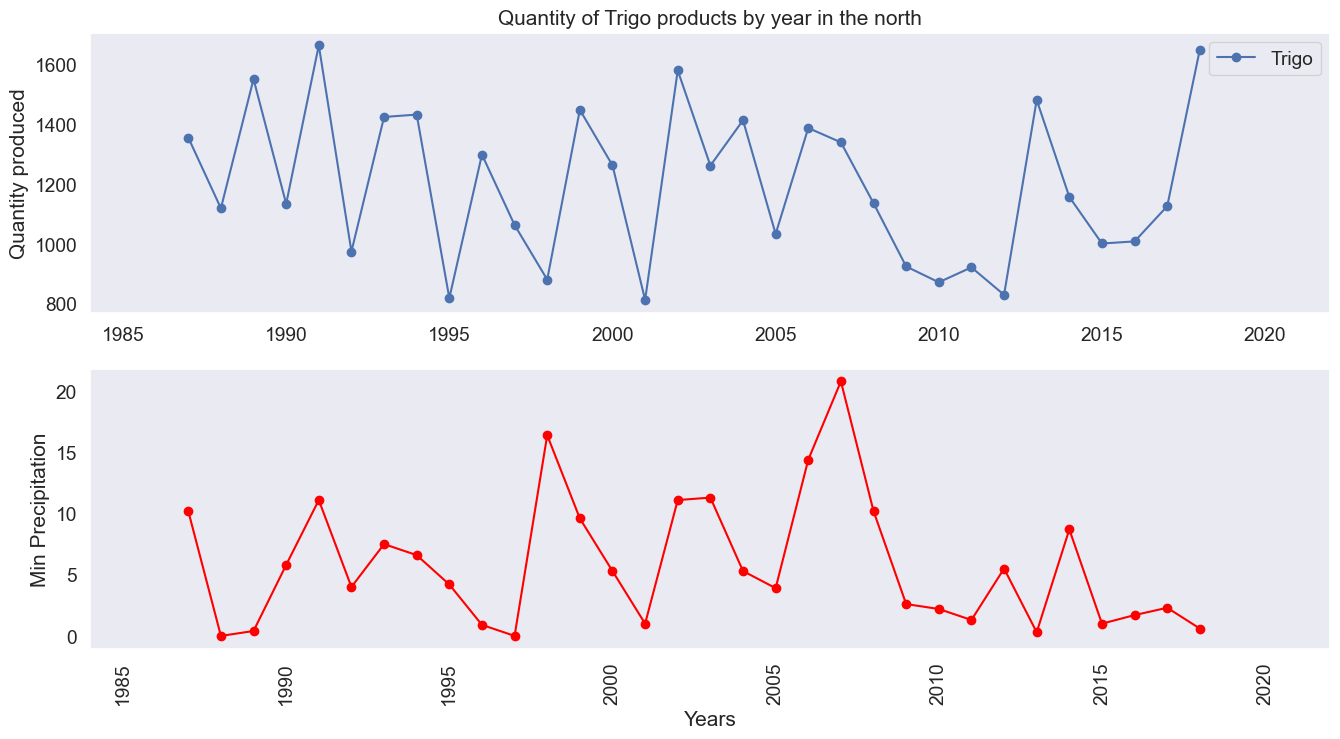

In [39]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
year = range(1987, 2019)
ax.plot(year, data_region.values, label="Trigo", marker="o")
ax2.plot(year, meteo_region["Prec_min"], color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced")
ax2.set_ylabel("Min Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the north")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

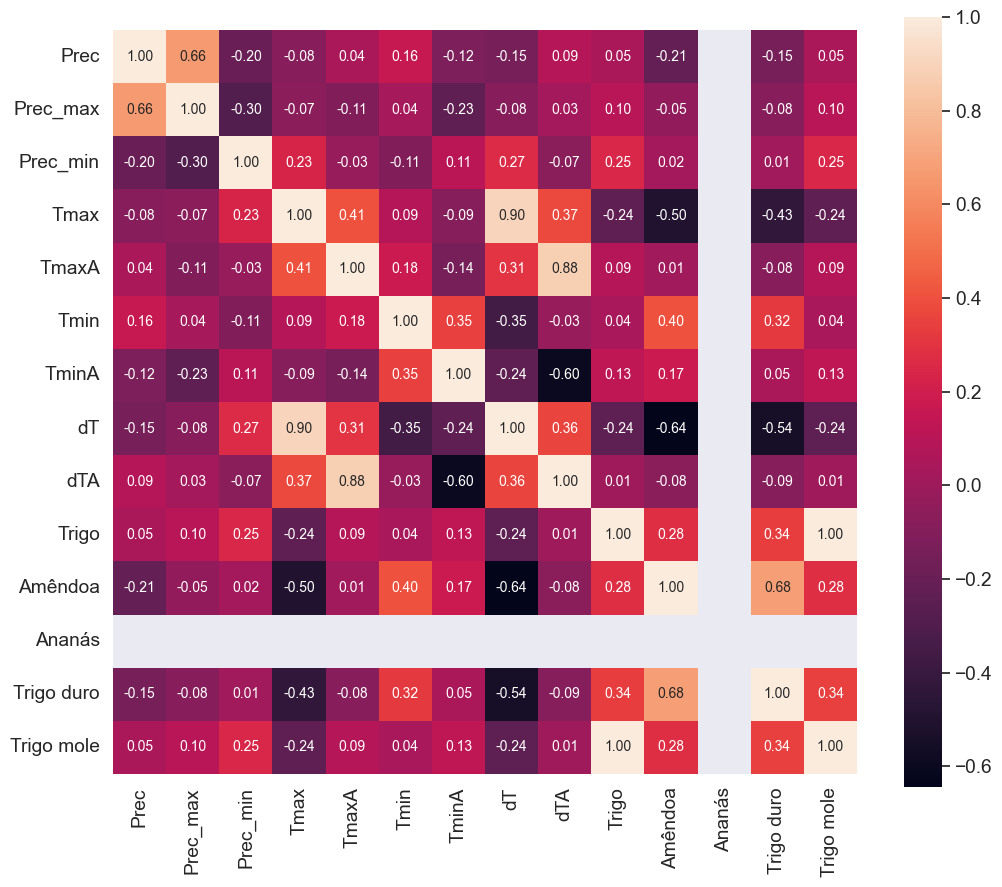

['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA', 'dT', 'dTA', 'Trigo', 'Amêndoa', 'Ananás', 'Trigo duro', 'Trigo mole']


In [40]:
# Repeating the study above for more products
region_study=11
meteo_region = meteo.xs(region_study)
data_region = data.xs(str(region_study))
index_to_plot= ["Trigo", "Amêndoa", "Ananás", "Trigo duro", "Trigo mole"]

index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(2019)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index("2019")
data_region = data_region[index_to_plot].iloc[range(index_min,index_max)]


f,ax = plt.subplots(figsize=(12, 10))
cols = list(meteo_region.columns)
cols += index_to_plot
cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()
# cols = cols.drop('Transported')
print(cols)

In [41]:
meteo_region.index

Int64Index([1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
            1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
            2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='Year')

### 4.3. Study of all correlations between production and meteo data

In [93]:
def table_corre(max_year=2010, delta=0, region=None, min_cor=0.7):
    if delta != 0:
        print(f"Correlation values for the products and meteo data, with products with more {delta} years than product")
    if region is None:
        region = [11, 16, 18, 15, 3, 2, 17]
    print(f'{"Region":<10}{"Correlation value":>20} {"Meteo":>20} {"Product":>40}')
    for region_code in region:
        meteo_region = meteo.xs(region_code)
        data_region = data.xs(str(region_code))
        index_min = list(meteo_region.index).index(1987)
        index_max = list(meteo_region.index).index(max_year)
        meteo_region = meteo_region.iloc[range(index_min+delta,index_max+delta)]

        index_min = list(data_region.index).index("1987")
        index_max = list(data_region.index).index(str(max_year))
        data_region = data_region.iloc[range(index_min,index_max)]

        cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
        list_nomes = list(meteo_region.columns)
        list_nomes.extend(data_region.columns)

        for k, sub_cm in enumerate(cm):
            if k <= 9: #Since 9 are the columns of meteo
                for k2, elem2 in enumerate(sub_cm):
                    if abs(elem2) > min_cor and k2 > 9 and region_code != 3:
                        print(f"{str(region_code)}{' ':>10}{elem2:>20}{list_nomes[k]:>20}{list_nomes[k2]:>40}")

In [94]:
#? Change min_cor to show higher/smaller correlations
table_corre(delta=0, min_cor=0.75)

Region       Correlation value                Meteo                                  Product
11           -0.8187393856458365                  dT                                   Ginja
11            -0.834516628025023                  dT                                 Nespera
11            -0.776625903969556                  dT                                  Tabaco
11           -0.7930971096957863                  dT                                 Toranja
18            0.7583288413307397                  dT                                  Ameixa
18           -0.7657966137960037                  dT                            Grão-de-bico
18             0.814173036724408                  dT      Principais culturas para indústria
18            0.7517699195254313                  dT                                    Pêra
18            -0.774731163899668                  dT                                    Romã
18            0.8207561075588693                  dT                  

/Users/joaoantonio/Documents/FAA_TitanicSpace/env_FAA/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/Users/joaoantonio/Documents/FAA_TitanicSpace/env_FAA/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide



In [92]:
#? Change min_cor to show higher/smaller correlations
table_corre(delta=1, min_cor=0.75)

Correlation values for the products and meteo data, with products with more 1 years than product
Region       Correlation value                Meteo                                  Product
18           -0.7640279604390913                  dT                                    Figo
18            0.8245579430500519                  dT                   Tomate para indústria
3            0.7969484438128287                Tmin                                  Batata
3            0.7775068032035697                Tmin                       Batata de regadio
3           -0.7804873908291732                Tmin                                Castanha
3            0.7808057244319734                Tmin                                 Centeio
3            0.7796005127765089                Tmin                                  Cevada
3            0.7759737378456434                Tmin                                 Damasco
3           -0.8936116749870533                Tmin                     

/Users/joaoantonio/Documents/FAA_TitanicSpace/env_FAA/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/Users/joaoantonio/Documents/FAA_TitanicSpace/env_FAA/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide



On the table above we can see that regions 11, 18 and 3 are the one with bigger correlations between metreology and products eficciency.

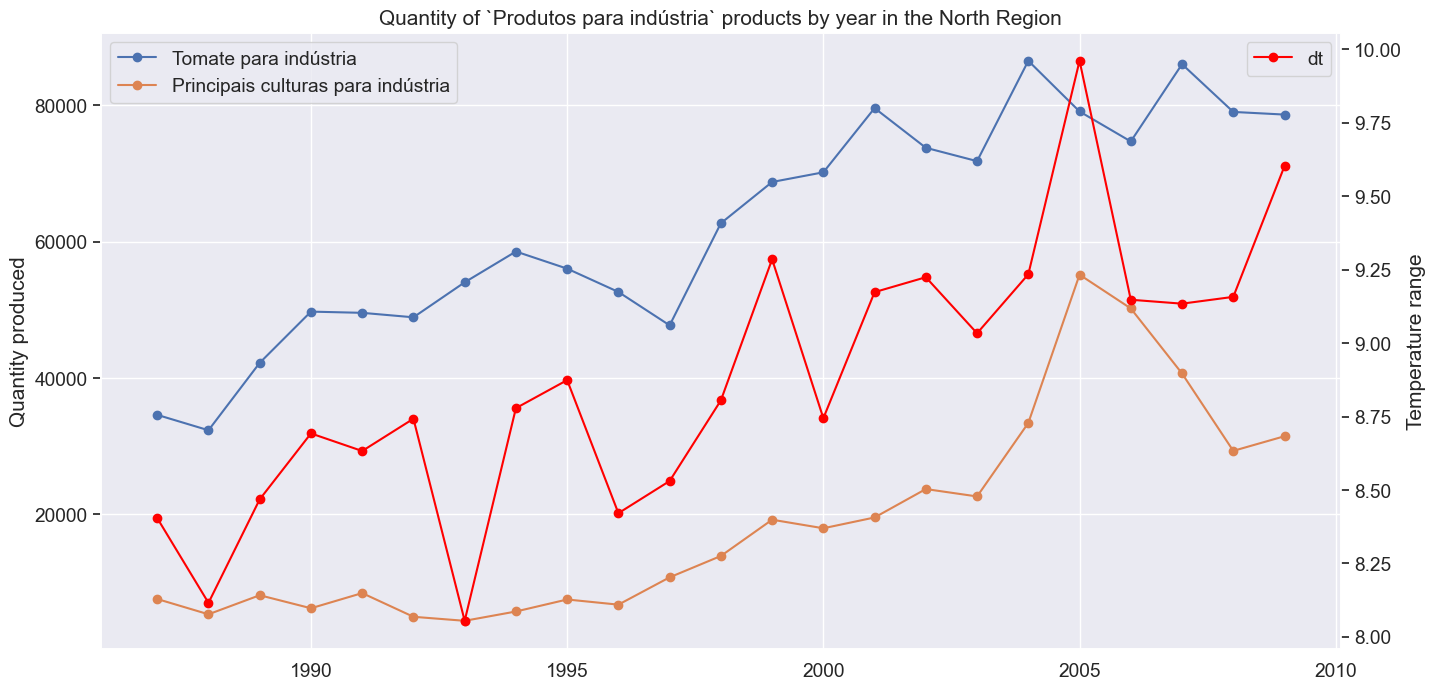

In [44]:
plt.figure(figsize=(16, 8))
region_code = 18
max_year = 2010
meteo_region = meteo.xs(region_code)
data_region = data.xs(str(region_code))
products = ["Tomate para indústria", "Principais culturas para indústria"]
index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(max_year)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index(str(max_year))
data_region = data_region[products].iloc[range(index_min,index_max)]

year = range(1987, max_year)
plt.plot(year, data_region.values, label=products, marker="o")
year = range(1987, max_year)
plt.ylabel("Quantity produced")
plt.legend()
ax2 = plt.twinx()
ax2.plot(year, meteo_region["dT"], color="red", marker="o", label="dt")
plt.ylabel("Temperature range")
plt.grid()
plt.title("Quantity of `Produtos para indústria` products by year in the North Region")
plt.xlabel("Years")
products.append("dT")
plt.legend()
plt.xticks(rotation="vertical")
plt.show()

## 5.Regplot<a id="5"></a>
To explore how one variable in the meteorologic boletin affects one production in linear terms

In [75]:
def meteo_data_region(region_code=11, min_year=1997, max_year=2010, products=None, delta=0):
    if products is None:
        products = ["Trigo"]
    meteo_region = meteo.xs(region_code)
    data_region = data.xs(str(region_code))
    index_min = list(meteo_region.index).index(min_year)
    index_max = list(meteo_region.index).index(max_year)
    meteo_region = meteo_region.iloc[range(index_min,index_max)]

    index_min = list(data_region.index).index(str(min_year-abs(delta)))
    index_max = list(data_region.index).index(str(max_year+abs(delta)))
    data_region = data_region[products].iloc[range(index_min+delta,index_max+delta)]
    year = range(1987, max_year)
    return year, data_region, meteo_region

In [76]:
def reg_plot_products(meteo_x="dT", products="Ameixa", max_year=2016, region=18, min_year=1988, delta=0):
     year, data_region, meteo_region = meteo_data_region(region_code=region, min_year=min_year, max_year=max_year, products=[products], delta=delta)
     data_region.index = data_region.index.map(str)
     meteo_region.index = meteo_region.index.map(str)
     df = meteo_region.join(data_region)
     
     cm = np.corrcoef(df[meteo_x], df[products])
     print(f"They have a correlation of {cm[0, 1]*100:.2f}")
     plt.figure(figsize=(16, 8))
     sns.regplot(data=df, x=meteo_x, y=products)
     for line in range(df.shape[0]):
          plt.text(df[meteo_x][line], df[products][line], df.index[line], horizontalalignment='left', size=10, color='black', weight='semibold')

They have a correlation of 81.84


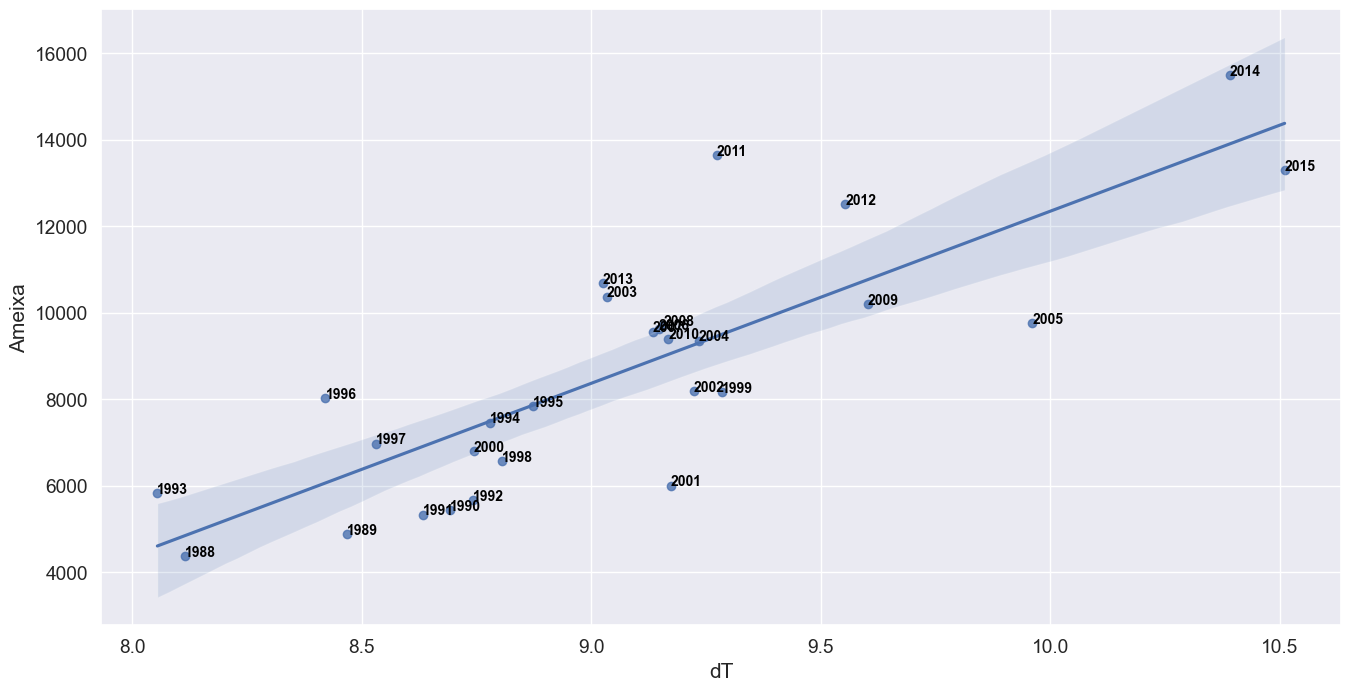

In [72]:
reg_plot_products()

They have a correlation of 79.98


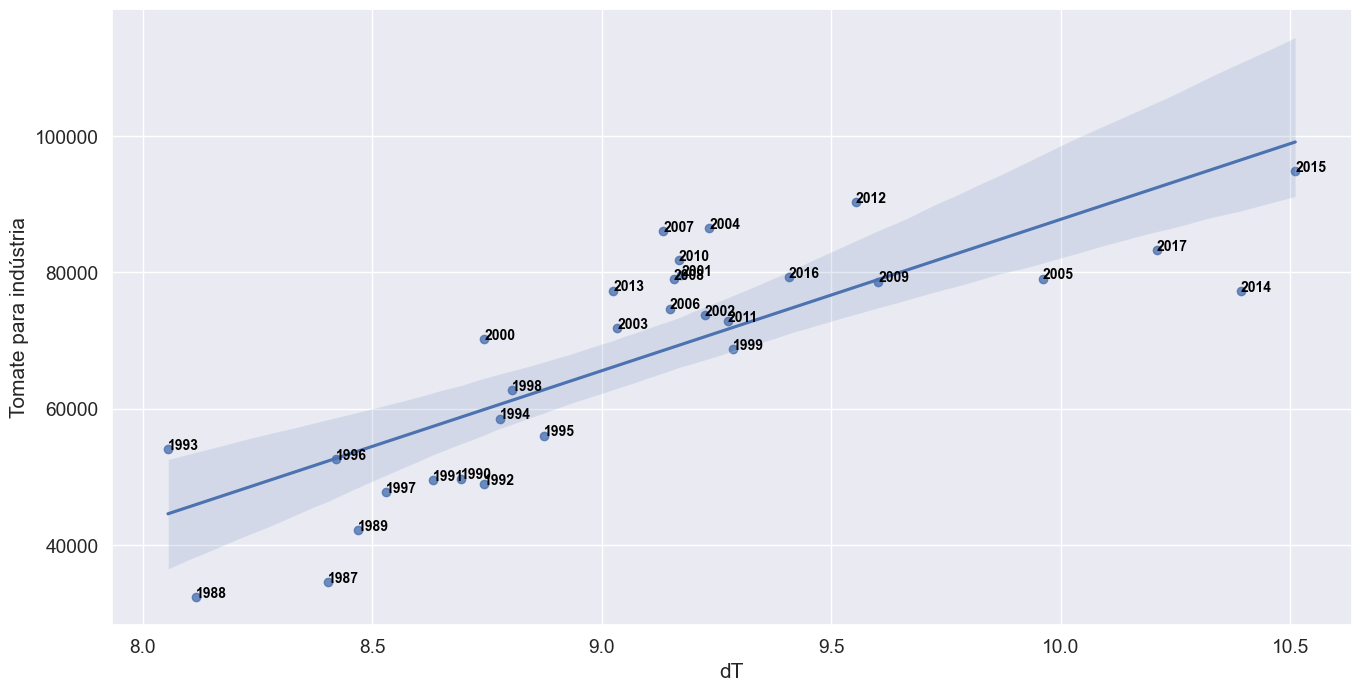

In [91]:
reg_plot_products(meteo_x="dT", products="Tomate para indústria", max_year=2018, region=18, min_year=1987)

They have a correlation of 84.16


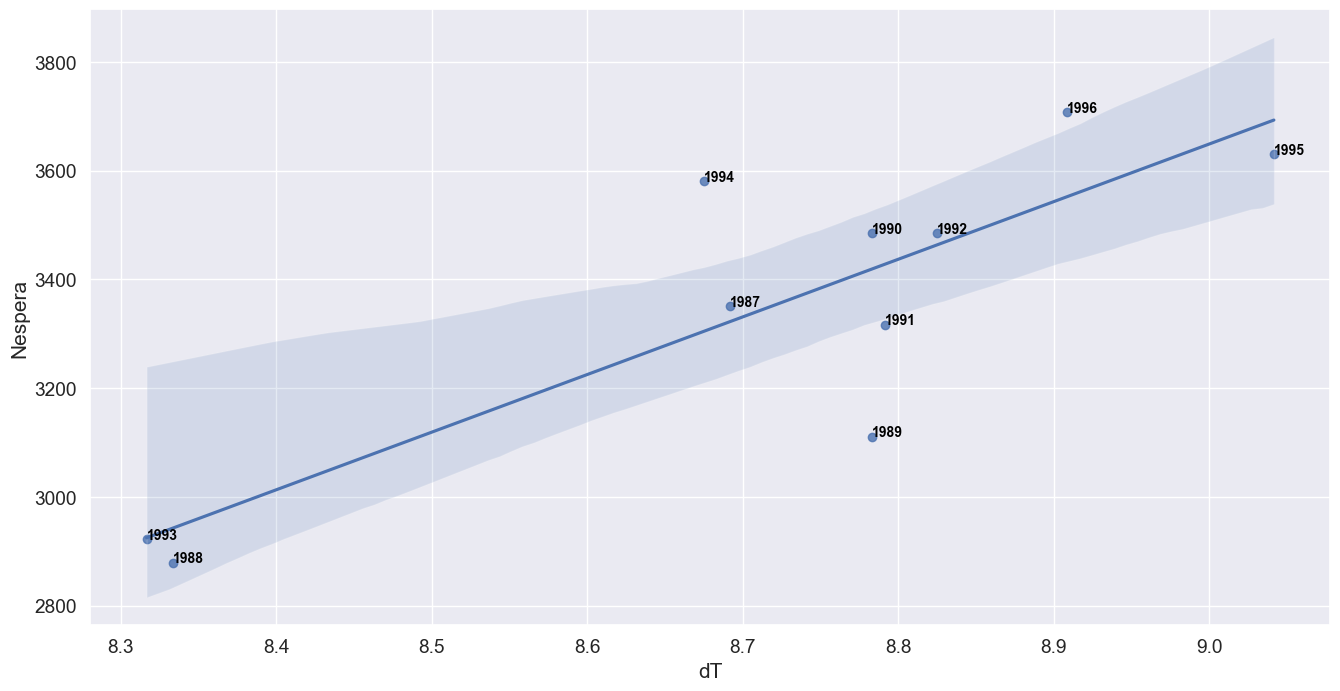

In [89]:
reg_plot_products(meteo_x="dT", products="Nespera", max_year=1997, region=11, min_year=1987)

## 6.Machine Learning<a id="6"></a>
We previously saw a few examples of regression plots, we will associate them to Machine learning models in the chapter. This way any user can, by simply placing a few values, obtain the estimation of the production by hectar to that product if the trends continue.

We decided to use 6 regression models and compare the results between them:
- Linear Regression - Uses a linear model to try to predict the results
- BayesianRidge - BayesianRidge estimates a probabilistic model of the regression proble . The prior for the coefficient is given by a spherical Gaussian.
- PassiveAggressiveRegressor - They are similar to the Perceptron in that they do not require a learning rate. However, contrary to the Perceptron, they include a regularization parameter C.
- TweedieRegressor - Generalized Linear Model with a Tweedie distribution.
- Ridge Regression - uses a L2 it tries to reduce the value of the variables with low value.
- Elastic Net - L1  and L2 priors for Regulation and can also make the weight of a uninportant variable equal to zero.


We have used a StandardScaler so that we could use Machine learning, without it, the higher values variables would gain more weight than others.

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

### 6.1. Regression Models

In [51]:
#? Select differnt variables:
products=["Tomate para indústria"] # default=["Tomate para indústria"]
region=18 # default=18
min_year=1987 # default=1987
max_year=2018 # default=2018
year_to_study = 2017 # default=2017

# Test for ["Trigo"] and see Elastic Net response

In [52]:
def train_model(products, max_year, region, min_year):
    year, data_region, meteo_region = meteo_data_region(region_code=region, min_year=min_year, max_year=max_year, products=products)

    scaler = StandardScaler()
    scaler.fit(meteo_region)
    X = pd.DataFrame(scaler.transform(meteo_region), columns=meteo_region.columns)

    scaler_y = StandardScaler()
    scaler_y.fit(data_region)
    y = pd.DataFrame(scaler_y.transform(data_region), columns=data_region.columns)

    lin_reg = LinearRegression().fit(X, y)
    bay_reg = BayesianRidge().fit(X, y)
    pas_reg = PassiveAggressiveRegressor().fit(X, y)
    las_reg = TweedieRegressor(max_iter=50000).fit(X, y)
    rid_reg = Ridge(max_iter=50000).fit(X, y)
    ela_reg = ElasticNet().fit(X, y)
    reg = [lin_reg, bay_reg, pas_reg, las_reg, rid_reg, ela_reg]
    return reg, X, y, scaler, scaler_y, data_region

def obtain_meteo(scaler, region_code=11, year_to_study=1997, use_scaler=False):
    meteo_region = meteo.xs(region_code)
    index_min = list(meteo_region.index).index(year_to_study)
    index_max = list(meteo_region.index).index(year_to_study+1)
    meteo_region = meteo_region.iloc[range(index_min,index_max)]
    return meteo_region


In [53]:
reg, X, y, scaler, scaler_y, y_no_norm = train_model(products, max_year, region, min_year)
x_pred = obtain_meteo(region_code=region, year_to_study=year_to_study, scaler=scaler)
x_pred2 = pd.DataFrame(scaler.transform(x_pred), columns=meteo_region.columns)

/Users/joaoantonio/Documents/FAA_TitanicSpace/env_FAA/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/joaoantonio/Documents/FAA_TitanicSpace/env_FAA/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/joaoantonio/Documents/FAA_TitanicSpace/env_FAA/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [54]:
import contextlib
regressions=['Linear', "BayesianRidge", "PassiveAggressive", "TweedieRegressor", "Ridge", "ElasticNet"]
preds = [regre.predict(x_pred) for regre in reg]

for k_regre, regre in enumerate(reg):
    print(f"The {regressions[k_regre]} Regression predicted {preds[k_regre]}")
    print(f"{regre.get_params(deep=False)}")
    with contextlib.suppress(AttributeError):
        print(f"{regre.n_iter_}")

The Linear Regression predicted [[20.37747831]]
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
The BayesianRidge Regression predicted [11.70678503]
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 300, 'normalize': 'deprecated', 'tol': 0.001, 'verbose': False}
7
The PassiveAggressive Regression predicted [17.76888383]
{'C': 1.0, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'n_iter_no_change': 5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
8
The TweedieRegressor Regression predicted [3.90294941]
{'alpha': 1.0, 'fit_intercept': True, 'link': 'auto', 'max_iter': 50000, 'power': 0.0, 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
7
The Ridg

We have decided to leave all the models in their default format this way a user can always change the products, and obtain new models with a relatively good hyper-parametrization.

We were only interested in one specific product then we could do a hyper parameter search on it, to improve that model even further.

In [55]:
preds2 = pd.DataFrame(scaler_y.inverse_transform(preds), columns=products)
preds2

<__array_function__ internals>:180: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,Tomate para indústria
0,403291.107594
1,260432.709874
2,360311.888314
3,131856.664500
4,365743.494879
5,101170.075045


In [56]:
y2 = pd.DataFrame(scaler_y.inverse_transform(y), columns=products)

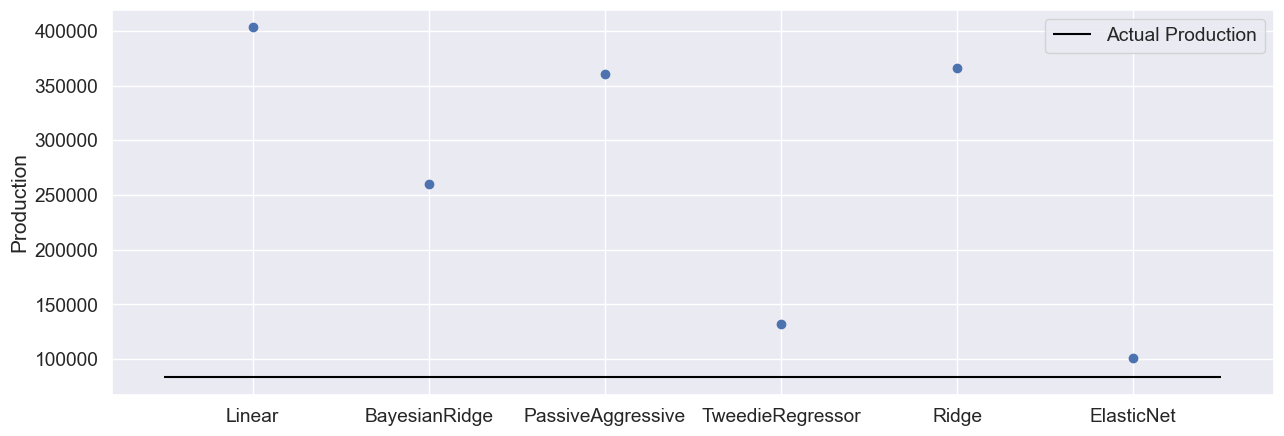

In [57]:
plt.scatter(regressions, preds2)
Val=y2[products].loc[y2.index[-1]] # Actual value of the production
plt.hlines(Val,-0.5,len(preds2)-0.5,colors='black',label='Actual Production')
plt.ylabel('Production')
plt.legend()
plt.show()

Above we can see the expected production according to the different regression models used, while the black line represents the actual production. This way we can see and compare the results between the different models.

Tweedie seems to perform very well in most cases; ElasticNet does great when there's high correlation between the production and one of the meteo features.

PassiveAggressive seems to do exceptionally bad (sometimes even negative production numbers!!!)

### 6.2. Explore predictions with made up meteorological data
Change any parameter from the X_pred and see how the models predictions change

In [58]:
x_pred2 = obtain_meteo(region_code=region, year_to_study=year_to_study, scaler=scaler, use_scaler=False)
x_pred2["Prec_max"]=300
x_pred2 = pd.DataFrame(scaler.transform(x_pred2), columns=meteo_region.columns)
x_pred2

,Prec,Prec_max,Prec_min,Tmax,TmaxA,Tmin,TminA,dT,dTA
0,-1.899801,1.025576,-0.554946,2.569557,0.743623,1.822382,0.210162,1.887656,0.423556


In [59]:
preds_new_original = [regre.predict(x_pred2) for regre in reg]
preds_new = pd.DataFrame(scaler_y.inverse_transform(preds_new_original), columns=products)
preds_new

<__array_function__ internals>:180: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,Tomate para indústria
0,93022.959690
1,88252.108819
2,100758.397469
3,81743.839473
4,91812.331851
5,73767.826793


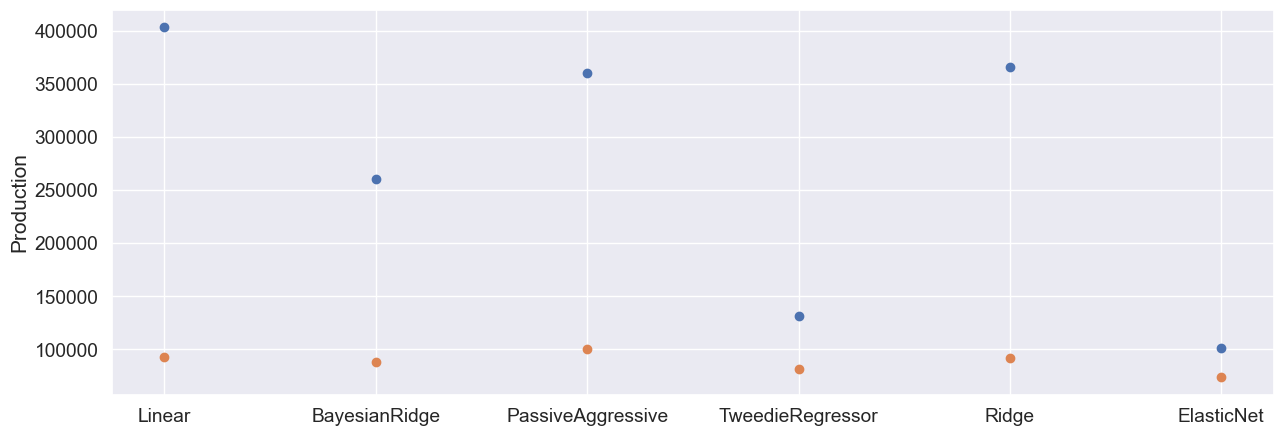

In [60]:
plt.scatter(regressions,preds2)
plt.scatter(regressions,preds_new)
plt.ylabel('Production')
plt.show()

### 6.3. Coefficient study for the various models

Linear
BayesianRidge
PassiveAggressive
TweedieRegressor
Ridge
ElasticNet


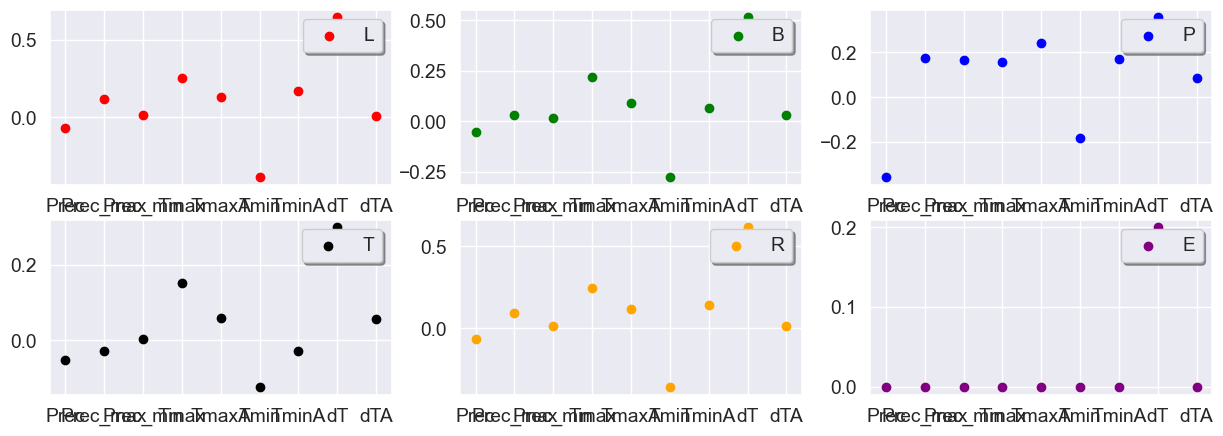

In [61]:
# plotting the coefficient score
# fig, ax = plt.subplots(figsize =(20, 10))
color = ["red","green","blue", "black","orange","purple","beige","brown","gray","cyan","magenta"]
for k in range(6):
    word = regressions[k]
    print(word)
    ax1 = plt.subplot(2, 3, k+1)
    ax1.scatter(X.columns, reg[k].coef_, color=color[k])
    ax1.legend(fancybox=True, shadow=True, labels=word)
plt.style.use('ggplot')
plt.show()

Note: the elastic net usually considers all coeficients as 0 unless there is a high correlation between one of the meteo features and the product. (For example 'Tomate para indústria' has a 82% correlation with dT)

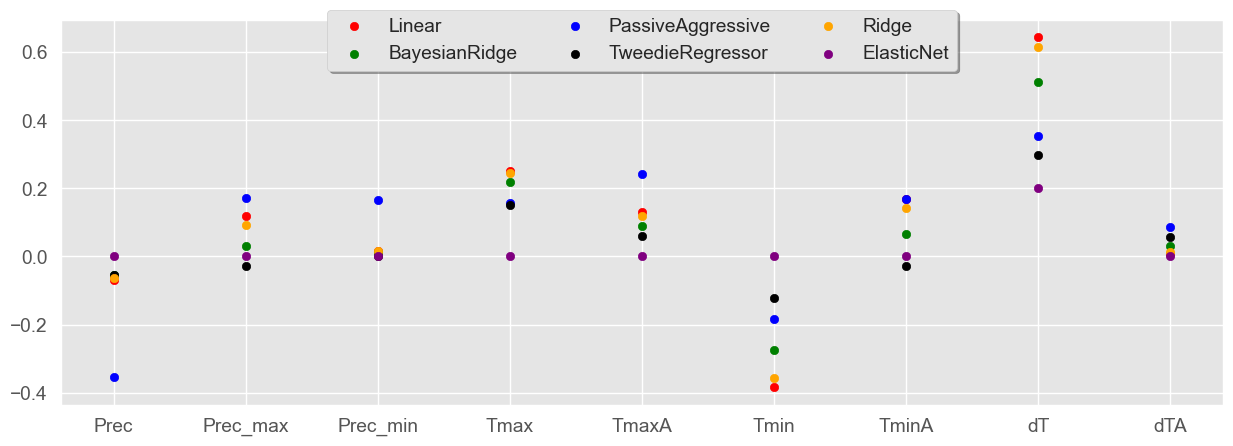

In [62]:
# plotting the coefficient score
fig, ax = plt.subplots()

for k in range(6):
    ax.scatter(X.columns, reg[k].coef_,color=color[k])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, labels=regressions)
plt.style.use('ggplot')
plt.show()

As we can see in the both images above, the elastic net only used dT,  and Tmin and dT were the variables where the coeficients more vary per model.

## 7.Feedback<a id="1"></a>

### 7.1 Future Work
- Expriment the crossing of information with Stamen Maps (where it possible to see the terrain) possible connection between terrain and production.
- Obtain data for Spain, to check how different would it be from Portugal.
- Experiment with some non-linear regression models, especially in cases with high correlation with one of the meteorological variables (for example, 'Tomate para indústria' appears to have a logarithmic relation with dT in region 18).
- Try to get information on when greenhouses (estufas) began being used in the multiple regions and compare the effects of the temperature before and after.
- Connect the stamen map information with the production to generate models that can predict given the soil, altitude, longitude, nearby by regions, what would be the expected production per hectare.

### 7.2 Assumptions
- That the variables that we are studying are the main contributors to the effects that we are studying
- **That Correlation causes causation** between the meterology and production efficiency

### 7.3 Critics
- Using **region names** instead of region codes would make the analisys more intuitive without costing too much on Code
- The precipitation variables that we used are of low relevance, we shoudl have used how many raining days did we had, or many days withotu rain, and how many consecutive raining days
- The Meteorology data for Madeira (region 3) is weird, some of that information is either capped at zero, or with strange values all toghether